In [1]:
!pwd

/share/home/tung6100/phD/semester3/FedMSSA/FedSSA-mSSA/results/SSA_analysis


In [2]:
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [3]:
# Load data
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


In [4]:
# Standardization data path
%cd ../../

/share/home/tung6100/phD/semester3/FedMSSA/FedSSA-mSSA


In [5]:
# FedLSTM_Imputed_Elec370_num_user_10_L_80_dim_70_MP_0_W79_best

In [6]:
'''Read data for each client'''
DATA_TYPE = 1 # 1 is for hankel and 0 is for page
datatype = "hankel" if DATA_TYPE else "page"
n_users = 370
missingVal = 40
data_path = f"results/imputed_data/mulTS/electricity_nusers_{n_users}_missing_{missingVal}"

M_ts = 324

imputed_data = []

for i in range(n_users):
    file_name = f"all_data_client_{i}.npy"
    file_path = os.path.join(data_path, file_name)
    data_client_i = np.load(file_path)
    imputed_data.append(data_client_i)

imputed_data = np.array(imputed_data)
imputed_data.shape

(10, 80, 11988)

In [7]:
num_data_per_user = int(370/n_users)
num_data_per_user

37

In [8]:
all_client_data = []
for user in range(n_users):
    data_client_i = imputed_data[user]
    for n in range(num_data_per_user):
        data_i = data_client_i[:, n*M_ts:(n+1)*M_ts]
        data_i_flatten = data_i.flatten('F')
        all_client_data.append(data_i_flatten)

all_client_data = np.array(all_client_data)
all_client_data.shape

(370, 25920)

In [9]:
# '''Test retrieving data from the first client'''
# client1_data = imputed_data[0, :, 324*2:324*(2+1)]
# client1_flatten_data = client1_data.flatten('F')
# client1_flatten_data.shape

[]

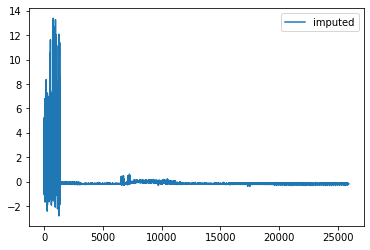

In [10]:
client1_flatten_data = all_client_data[2]
plt.plot(client1_flatten_data, label="imputed")
plt.legend()
plt.plot()

In [11]:
# Jiayu4: solve mulTS prediction results
"""Preprocess data"""
data = pd.read_csv('results/SSA_analysis/LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('Data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
aggregated_data = data_2.groupby(['time']).agg(agg_dict)
print('Data aggregated by hour')
aggregated_data.shape

Data loaded..
Data aggregated by hour


(26304, 370)

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [13]:
def set_train_test():
    data_train = normalized_data.iloc[:25968,:] #25600; 25968; 26082
    data_test = normalized_data.iloc[25968:,:]
    return data_train, data_test

In [14]:
data_train, data_test = set_train_test()
data_train.shape, data_test.shape

((25968, 370), (336, 370))

In [15]:
data_train = data_train.iloc[25968%80:,:] # second range, note its not T%L+1 due to python index
all_client_data = copy.deepcopy(data_train.values.T)

all_client_data.shape

(370, 25920)

In [16]:
def load_test_data():
  results_path = f"results/test_data/"
  file_name = f"test_data_336steps.npy"
  file_path = os.path.join(results_path, file_name)
  return_file = np.load(file_path)
  return return_file

In [17]:
from torch.utils.data import Dataset
import torch
# Create dataset
class timeseries(Dataset):
  def __init__(self, x, y):
    self.x = torch.Tensor(x)
    self.y = torch.Tensor(y)
    self.len = x.shape[0]
    # print(self.len)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx] 
  
  def __len__(self):
    return self.len

In [18]:
train_data = copy.deepcopy(all_client_data)
train_data.shape

(370, 25920)

In [19]:
test_data = load_test_data()
test_data.shape

(370, 336)

In [20]:
# Define the test settings
window = 40
prediction_steps = 24
num_TS = 370

In [21]:
# Get the last window of train data
last_window = train_data[:, -window:]

# Get actual data for prediction steps
# actual_steps = test_data[:, -prediction_steps:]
actual_steps = test_data[:, :prediction_steps] # Jiayu4: solve mulTS prediction results

last_window.shape, actual_steps.shape

((370, 40), (370, 24))

In [22]:
def create_np_data(user_test_data, prediction_steps=24):
    x_test = []
    y_test = []

    for i in range(prediction_steps):
        x_test.append(user_test_data[i:i+window])
        y_test.append(user_test_data[i+window])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_test, y_test

In [23]:
def load_model(model_name):
    model_path = os.path.join("models", "mulTS", "Imputed_Elec370", model_name + ".pt")
    model = torch.load(model_path)
    return model

In [24]:
!pwd

/share/home/tung6100/phD/semester3/FedMSSA/FedSSA-mSSA


In [25]:
model_name = f"FedLSTM_Imputed_Elec370_num_user_{n_users}_L_80_dim_40_MP_{missingVal}_W40_{datatype}"
# model_name = f"FedLSTM_Imputed_Elec370_num_user_{n_users}_L_80_dim_40_MP_{missingVal}_W79"

# model_name = "FedLSTM_Imputed_Elec370_num_user_37_L_80_dim_40_MP_20_W40"
model = load_model(model_name)
model

LSTM_nn(
  (lstm): LSTM(1, 5, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Config to get the performance:
- missing 0: python3 main.py --dataset Imputed_Elec370 --algorithm FedLSTM --batch_size 64 --learning_rate 0.001 --fac 0.2 --num_global_iters 20 --local_epochs 1 --num_users 10 --mulTS 1 --missingVal 0 --datatype hankel


In [27]:
diff_list = []
y_pred = []
y_true = []
for user_id in range(num_TS):
    # print(f"----------Client {user_id}----------")
    user_last_window = last_window[user_id]
    user_actual_steps = actual_steps[user_id]
    user_test_data = np.concatenate((user_last_window, user_actual_steps), axis=None)
    # print(f"{user_last_window.shape}, {user_actual_steps.shape}, {user_test_data.shape}")

    """Create input data for data model"""
    # Create np data
    x_test, y_test = create_np_data(user_test_data=user_test_data, prediction_steps=prediction_steps)
    # Cretate dataset
    test_set = timeseries(x_test, y_test)
    # Prediction
    input = test_set[:][0].view(-1,window,1)
    actual = test_set[:][1].view(-1)
    input = input.to(device)
    test_pred = model(input).view(-1)
    predictions_24 = test_pred.cpu().detach().numpy()
    actual = actual.numpy()
    diff = predictions_24 - actual
    diff_list.append(diff)
    # plt.plot(predictions_24, label='predicted')
    # plt.plot(actual, label='original')
    # plt.legend()
    # plt.plot()
    # plt.show()
    # break
    y_pred.append(predictions_24)
    y_true.append(actual)
diff_np = np.array(diff_list)
rmse = np.sqrt(np.mean(np.square(diff_np)))
print(f"RMSE FedMSSA + LSTM: {rmse}")

/home/tung6100/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


RMSE FedMSSA + LSTM: 0.24857673048973083


In [28]:
y_pred_np = np.array(y_pred)
y_true_np = np.array(y_true)

y_pred_np.shape, y_true_np.shape

((370, 24), (370, 24))

In [29]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

# Function to estimate accuracy for one user
def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

# Function to estimate average accuracy for multiple users
def average_acc(y_true, y_pred):
    n_users = y_true.shape[0]
    acc_list = []
    for i in range(n_users):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]
        acc = accuracy_Testset(y_true_i, y_pred_i)
        acc_list.append(acc)
    acc_np = np.array(acc_list)
    # print(acc_np)
    avg_acc = np.mean(acc_np)
    return avg_acc

In [30]:
MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_np, y_pred_np)
avg_acc = average_acc(y_true_np, y_pred_np)
print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}")
print(f"Avg_Acc: {avg_acc}")

MSE: 0.06179039552807808, RMSE: 0.24857674539089203, MAE: 0.15825210511684418, MAPE: 88.90265226364136
Avg_Acc: 65.82843713278496
